# ASHRAE - Great Energy Predictor III

### General Project / Past Competition Information
- Aim: (Accurately) Predicting energy consumption in commercial buildings.
- Dataset: 20 million rows, covering three years of hourly data from 2,380 meters ({0: electricity, 1: chilledwater, 2: steam, 3: hotwater}) across 1,448 commercial buildings

Possible features: year_built (building_age), air_temperature, square_feet (by energy_intensity -> meter/sqft), wind_speed?, primary_use??, hour?, weekday?

Kaggle Competition link: https://www.kaggle.com/competitions/ashrae-energy-prediction/data 

### Issues & Questions
- Data size is big, not easy to process each time. Sampling?
- is there a way to cache data and not have to load it from scratch each time? should we save the random sample I selected or not?
- Should I fillna() the missing data with median etc.? - air_temperature, cloud_coverage? or dropna()?



### Ideas / Solutions:
Clarence:
- fraction by 1% or 0.5%
- aggregate data (not hourly but daily sum (for short-term), monthly sum (for longer-term) etc.) -> loss of time-series data (HVAC load may differ in a day)
- go with one building and scale up later -> may not generalize later? (instead, start with single site (same climate zone) and meter?)

## 1. Libraries & Data Set-up

In [2]:
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [4]:
train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/train.csv')
building_metadata = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/building_metadata.csv')
weather_train = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_train.csv')

test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/test.csv')
weather_test = pd.read_csv('/Users/meltemsahin/Documents/GitHub/ashrae-energy-prediction/data/weather_test.csv')

In [5]:
print("-----------\nTrain Data:")
display(train.head())
print(train.info())
print(f'Size of train data: {train.shape}')
print("-----------\nBuilding Metadata:")
display(building_metadata.head())
print(building_metadata.info())
print(f'Size of building_metadata data: {building_metadata.shape}')
print("-----------\nWeather Train Data:")
display(weather_train.head())
print(weather_train.info())
print(f'Size of weather_train data: {weather_train.shape}')

'''
Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)
'''

-----------
Train Data:


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
Size of train data: (20216100, 4)
-----------
Building Metadata:


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.1+ KB
None
Size of building_metadata data: (1449, 6)
-----------
Weather Train Data:


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None
Size of weather_train data: (139773, 9)


'\nSize of train_df data (20216100, 4)\nSize of weather_train_df data (139773, 9)\nSize of weather_test_df data (277243, 9)\nSize of building_meta_df data (1449, 6)\n'

### Merging train + building_metadata + weather_train -> **'train_merged'** (via 'building_id' and 'site_id')

In [6]:
train_merged = pd.merge(train, building_metadata, on='building_id', how='left')
train_merged = pd.merge(train_merged, weather_train, on=['site_id', 'timestamp'], how='left')

display(train_merged.head()) # train + building_metadata + weather_train 

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


### Checking missing data (train_merged)

In [7]:
missing_values = train_merged.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

total = train_merged.isnull().sum().sort_values(ascending = False)
percent = (train_merged.isnull().sum()/train_merged.isnull().count()*100).sort_values(ascending = False)
missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
missing__train_data['Percent (%)'] = missing__train_data['Percent (%)'].map('{:.2f}'.format)
display(missing__train_data)

Missing values in each column:
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64


,Total,Percent (%)
floor_count,16709167,82.65
year_built,12127645,59.99
cloud_coverage,8825365,43.66
precip_depth_1_hr,3749023,18.54
wind_direction,1449048,7.17
sea_level_pressure,1231669,6.09
wind_speed,143676,0.71
dew_temperature,100140,0.50
air_temperature,96658,0.48
building_id,0,0.00


### Sampling (For faster processing)

In [8]:
train_sample = train_merged.sample(frac=0.1, random_state=42)
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2021610 entries, 14245562 to 466022
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 262.2+ MB


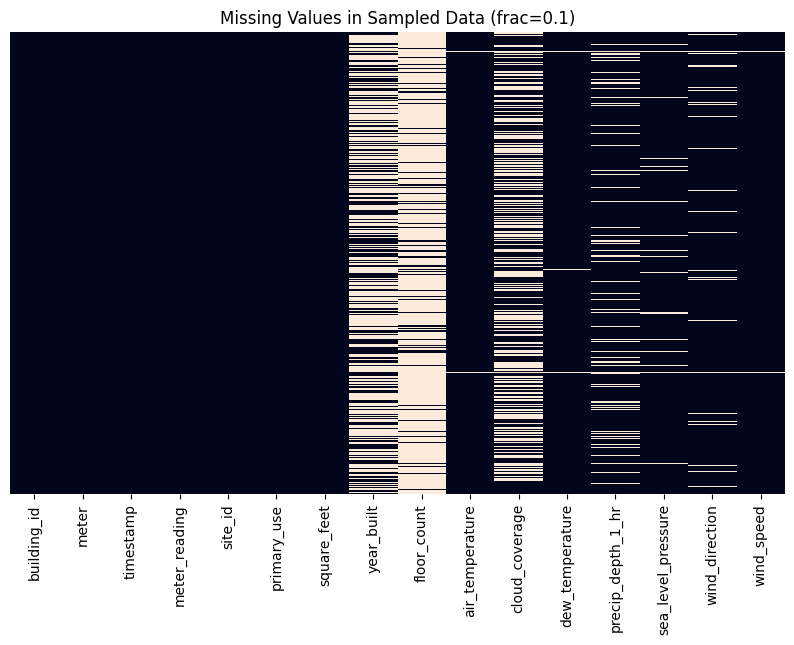

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_sample.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values in Sampled Data (frac=0.1)")
plt.show()

Should I dropna() or fillna()? by median

In [10]:
# complete_buildings = train_merged.dropna()
# display(complete_buildings.head())
# print(f'Number of buildings with all features filled: {len(complete_buildings)}')

# or

# train_sample['air_temperature'].fillna(train_sample['air_temperature'].median(), inplace=True)
# train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
# train_sample['day_of_week'] = pd.to_datetime(train_sample['timestamp']).dt.dayofweek


# or more generally:
# fillna() for numerical columns
# num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
#             'sea_level_pressure', 'wind_direction', 'wind_speed', 'year_built']

# for col in num_cols:
#     train_sample[col].fillna(train_sample[col].median(), inplace=True)

# # dropna() floor_count (Too many missing values)
# train_sample.drop(columns=['floor_count'], inplace=True)

Check the entries where a feature is missing:

In [11]:
# cols_air_temp_missing = train_sample[train_sample['air_temperature'].isnull()]
# cols_air_temp_missing = cols_air_temp_missing.sort_values(by='building_id', ascending=False)
# cols_air_temp_missing

In [12]:
# # outlier detection
# factor = 1.5
# Q1 = train_sample['log_meter_reading'].quantile(0.25)
# Q3 = train_sample['log_meter_reading'].quantile(0.75)
# IQR = Q3 - Q1 # interquartile range 0.25-0.75
# lower_bound = Q1 - factor * IQR
# upper_bound = Q3 + factor * IQR
# train_sample = train_sample[(train_sample['log_meter_reading'] >= lower_bound) &
#                             (train_sample['log_meter_reading'] <= upper_bound)]

In [13]:
# segmentation by Meter Type:
electric_data = train_sample[train_sample['meter'] == 0]
chilled_water_data = train_sample[train_sample['meter'] == 1]
steam_data = train_sample[train_sample['meter'] == 2]
hotwater_data = train_sample[train_sample['meter'] == 3]

In [14]:
train_merged.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


Building yearly meter dataset

In [15]:
train_merged['timestamp'] = pd.to_datetime(train_merged['timestamp'])
train_merged['year'] = train_merged['timestamp'].dt.year
yearly_meter_aggregation = train_merged.groupby(['building_id', 'year'])['meter_reading'].sum().reset_index()

yearly_meter_aggregation = pd.merge(yearly_meter_aggregation, building_metadata[['building_id', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count']], on='building_id', how='left')
display(yearly_meter_aggregation.head())

,building_id,year,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,2016,1.286461e+06,0,Education,7432,2008.0,NaN
1,1,2016,6.576176e+05,0,Education,2720,2004.0,NaN
2,2,2016,1.278194e+05,0,Education,5376,1991.0,NaN
3,3,2016,2.069071e+06,0,Education,23685,2002.0,NaN
4,4,2016,8.578074e+06,0,Education,116607,1975.0,NaN


Feature Selection & Engineering (year_built (building_age), air_temperature, square_feet (by energy_intensity -> meter/sqft), wind_speed?, primary_use??, hour?, weekday?)

In [16]:
train_sample['building_age'] = pd.to_datetime(train_sample['timestamp']).dt.year - train_sample['year_built']
# train_sample['building_age'].fillna(train_sample['building_age'].median(), inplace=True)
# or train_sample['building_age].dropna(inplace=True) ???

thresh_temp = 18 # outside air_temp
train_sample['HDH'] = train_sample['air_temperature'].apply(lambda x: max(thresh_temp - x, 0)) # heating degree hours
train_sample['CDH'] = train_sample['air_temperature'].apply(lambda x: max(x - thresh_temp, 0)) # cooling degree days

train_sample['energy_intensity'] = train_sample['meter_reading'] / train_sample['square_feet']

train_sample['wind_chill_effect'] = train_sample['wind_speed'] * (thresh_temp - train_sample['air_temperature']) # + -> heat loss, - -> can work as natural cooling


train_sample['hour'] = pd.to_datetime(train_sample['timestamp']).dt.hour
train_sample['weekday'] = pd.to_datetime(train_sample['timestamp']).dt.weekday # 1,2,3,4,5,6,7

# train_sample['is_peak'] = train_sample['hour'].apply(lambda x: 1 if 7 <= x <= 19 else 0)
# train_sample['is_night'] = train_sample['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

train_sample.sort_values(by='building_id', inplace=True)
train_sample

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,sea_level_pressure,wind_direction,wind_speed,building_age,HDH,CDH,energy_intensity,wind_chill_effect,hour,weekday
18000581,0,0,2016-11-22 09:00:00,218.419,0,Education,7432,2008.0,NaN,6.1,...,1020.1,0.0,0.0,8.0,11.9,0.0,0.029389,0.00,9,1
12658387,0,0,2016-08-19 11:00:00,299.644,0,Education,7432,2008.0,NaN,24.4,...,1017.9,0.0,0.0,8.0,0.0,6.4,0.040318,-0.00,11,4
15173290,0,0,2016-10-03 03:00:00,251.865,0,Education,7432,2008.0,NaN,25.6,...,1015.3,280.0,1.5,8.0,0.0,7.6,0.033889,-11.40,3,0
5102614,0,0,2016-04-06 18:00:00,0.000,0,Education,7432,2008.0,NaN,24.4,...,1021.4,90.0,4.1,8.0,0.0,6.4,0.000000,-26.24,18,2
13671623,0,0,2016-09-06 13:00:00,245.039,0,Education,7432,2008.0,NaN,25.0,...,1021.3,10.0,3.1,8.0,0.0,7.0,0.032971,-21.70,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7814604,1448,0,2016-05-24 23:00:00,2.775,15,Office,92271,2001.0,NaN,NaN,...,NaN,NaN,NaN,15.0,NaN,NaN,0.000030,NaN,23,1
11897125,1448,0,2016-08-05 15:00:00,4.225,15,Office,92271,2001.0,NaN,25.0,...,1014.4,160.0,4.6,15.0,0.0,7.0,0.000046,-32.20,15,4
10753515,1448,0,2016-07-16 04:00:00,3.850,15,Office,92271,2001.0,NaN,16.1,...,1015.2,0.0,0.0,15.0,1.9,0.0,0.000042,0.00,4,5
19099251,1448,0,2016-12-12 06:00:00,4.650,15,Office,92271,2001.0,NaN,-3.3,...,1014.0,160.0,7.7,15.0,21.3,0.0,0.000050,164.01,6,0


# Assignment 2

In [17]:
plt.style.use('ggplot')
color = 'darkblue'

1. Histogram - log_meter_reading distribution

In [18]:
# # remove zero meter readings???
# train_sample = train_sample[train_sample['meter_reading'] > 0]
train_sample['log_meter_reading'] = np.log1p(train_sample['meter_reading'])

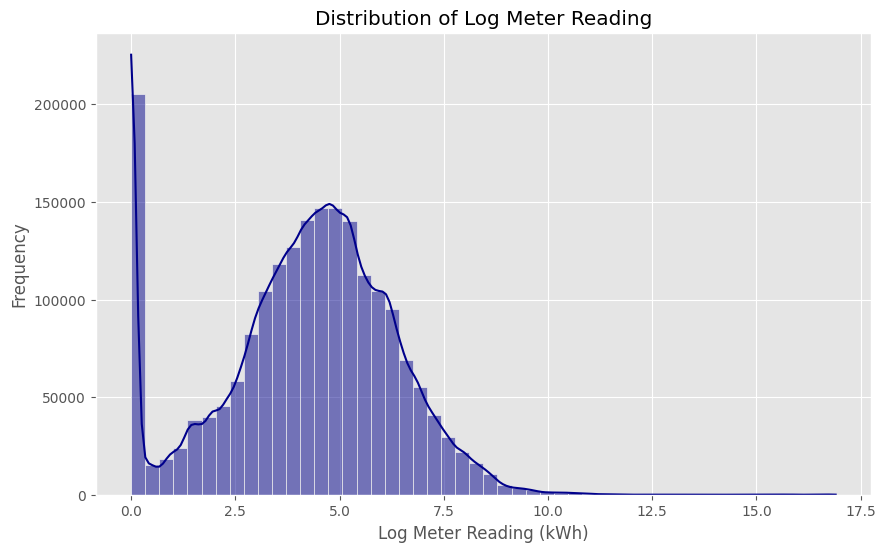

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(train_sample['log_meter_reading'], bins=50, kde=True, color='darkblue')
plt.title('Distribution of Log Meter Reading')
plt.xlabel('Log Meter Reading (kWh)')
plt.ylabel('Frequency')
plt.show()

2. Scatter Plot - relationship bw log_meter_reading (energy use) and air_temperature

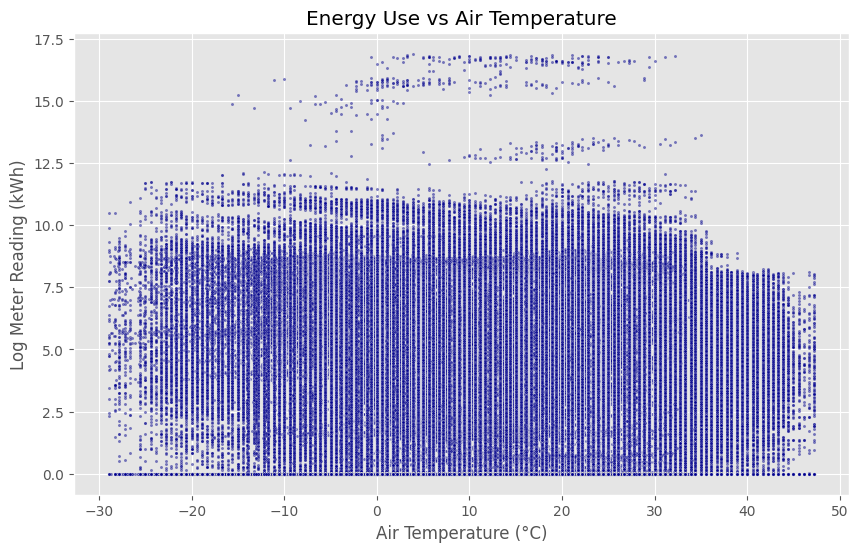

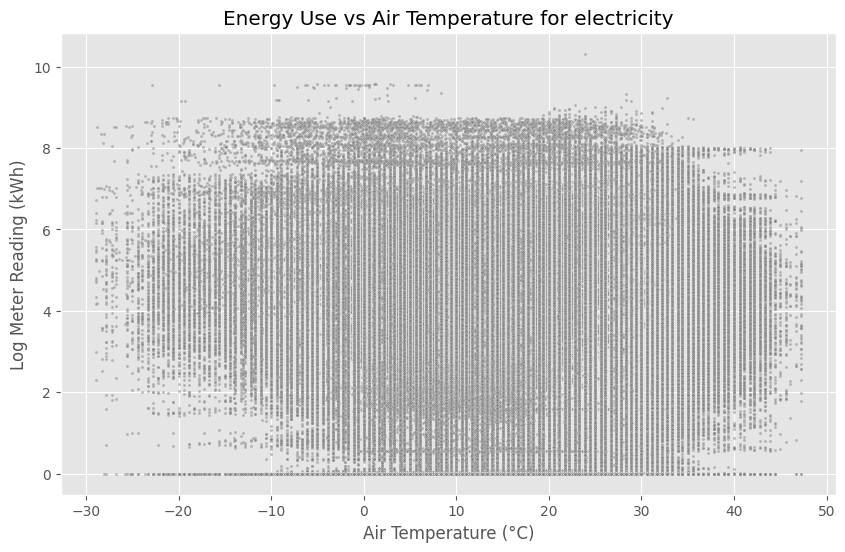

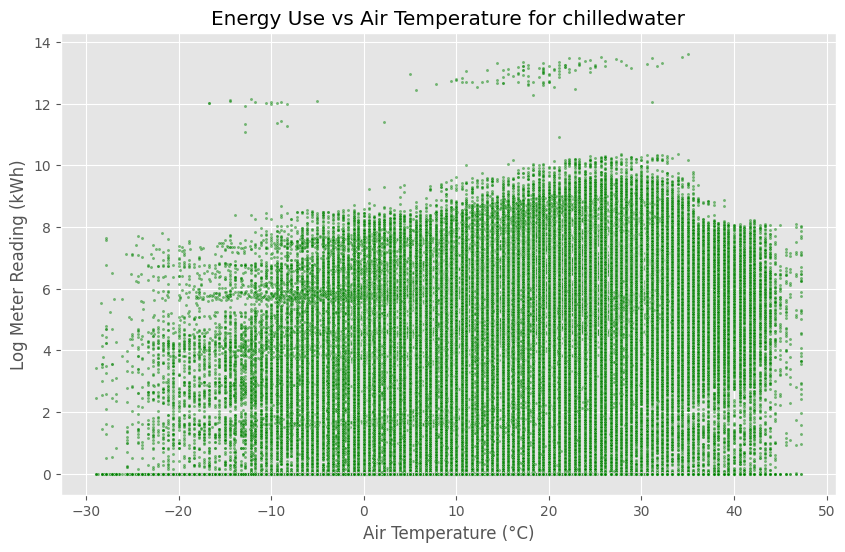

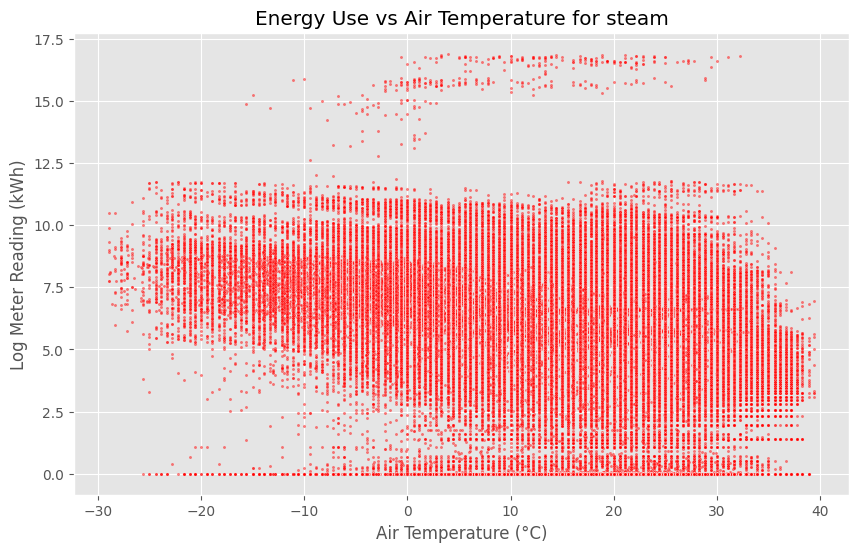

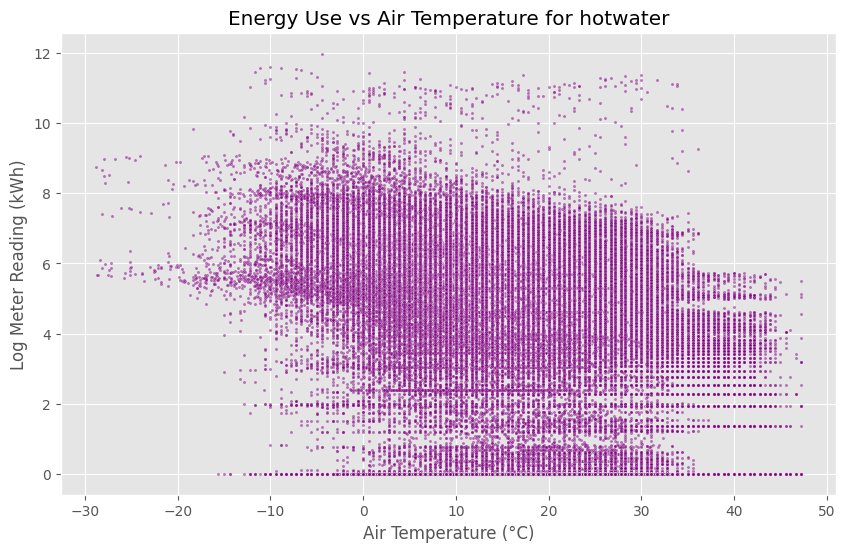

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='air_temperature', y=train_sample['log_meter_reading'], s=5, color=color, alpha=0.5, data=train_sample)
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Log Meter Reading (kWh)')
plt.title('Energy Use vs Air Temperature')
plt.show()

# for different meter types
colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'purple'}
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

for meter_id, meter_name in meter_types.items():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='air_temperature', y='log_meter_reading', s=5, color=colors[meter_id], alpha=0.5, data=train_sample[train_sample['meter'] == meter_id])
    plt.xlabel('Air Temperature (°C)')
    plt.ylabel('Log Meter Reading (kWh)')
    plt.title(f'Energy Use vs Air Temperature for {meter_name}')
    plt.show()

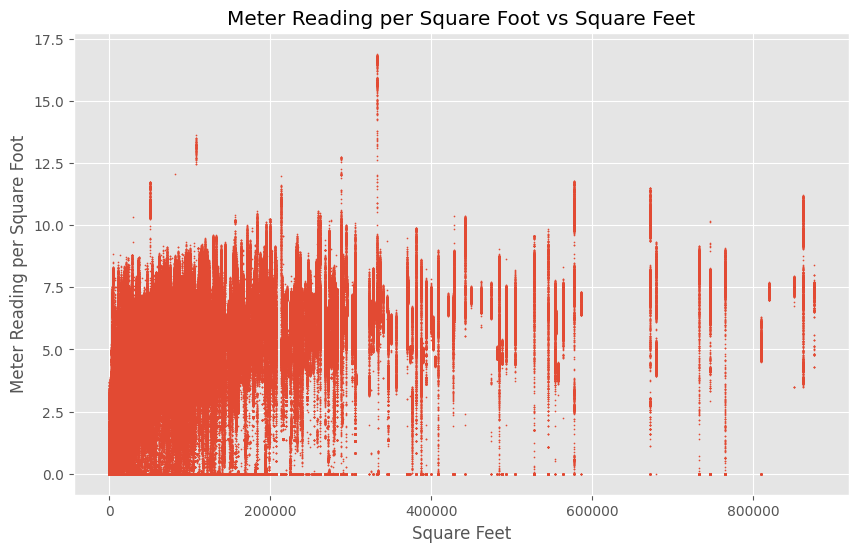

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(train_sample['square_feet'], train_sample['log_meter_reading'], s=0.5)
plt.xlabel('Square Feet')
plt.ylabel('Meter Reading per Square Foot')
plt.title('Meter Reading per Square Foot vs Square Feet')
plt.show()

3. Correlation Heatmap - relationship between air_temperature and log_meter_reading.

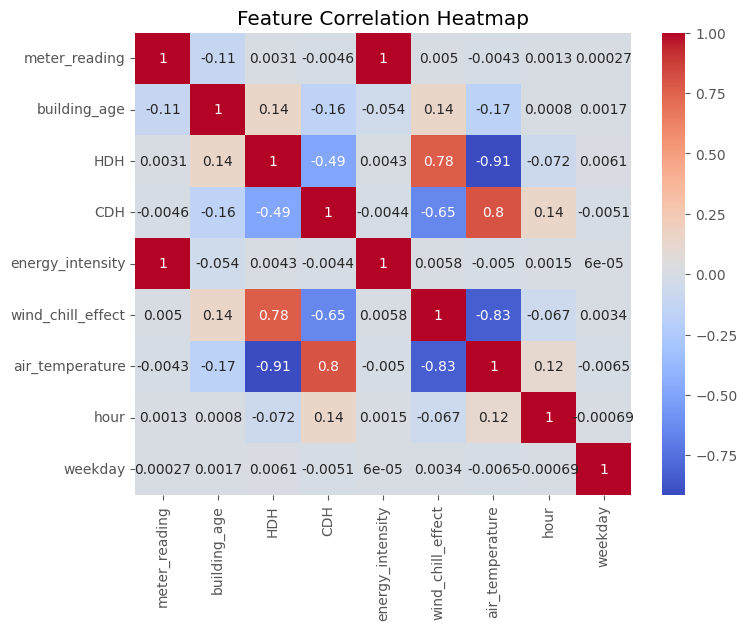

In [22]:
plt.figure(figsize=(8, 6))
corr = train_sample[['meter_reading', 'building_age', 'HDH', 'CDH', 'energy_intensity', 'wind_chill_effect', 'air_temperature', 'hour', 'weekday']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Linear Regression Model

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features = ['building_age', 'HDH', 'CDH', 'energy_intensity', 'wind_chill_effect', 'air_temperature', 'hour', 'weekday']
target = 'log_meter_reading'

X = train_sample[features]
y = train_sample[target]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Is it a right move???

In [24]:
print(X_train.isnull().sum())

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

print(X_train.isnull().sum())
print(X_train.info())

building_age         969829
HDH                    7844
CDH                    7844
energy_intensity          0
wind_chill_effect     11661
air_temperature        7844
hour                      0
weekday                   0
dtype: int64
building_age         0
HDH                  0
CDH                  0
energy_intensity     0
wind_chill_effect    0
air_temperature      0
hour                 0
weekday              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 640615 entries, 6487186 to 2354291
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_age       640615 non-null  float64
 1   HDH                640615 non-null  float64
 2   CDH                640615 non-null  float64
 3   energy_intensity   640615 non-null  float64
 4   wind_chill_effect  640615 non-null  float64
 5   air_temperature    640615 non-null  float64
 6   hour               640615 non-null  int32  
 7   weekday 

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

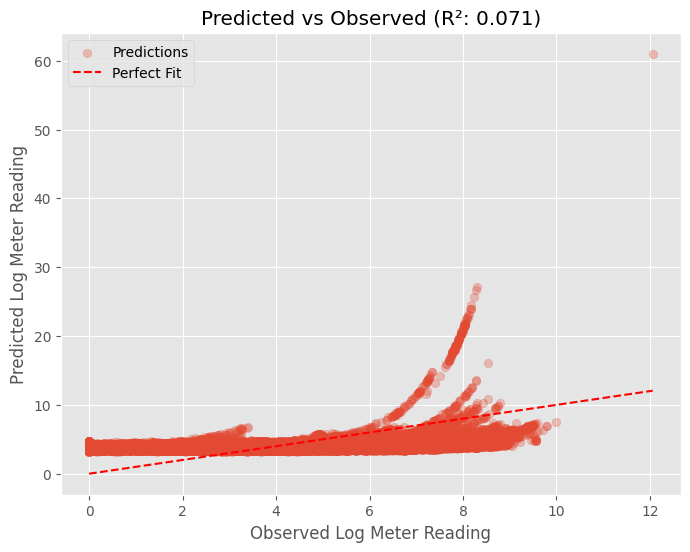

R² Score: 0.071


In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title(f'Predicted vs Observed (R²: {r2:.3f})')
plt.xlabel('Observed Log Meter Reading')
plt.ylabel('Predicted Log Meter Reading')
plt.legend()
plt.show()

print(f"R² Score: {r2:.3f}")

### Accuracy VS Complexity

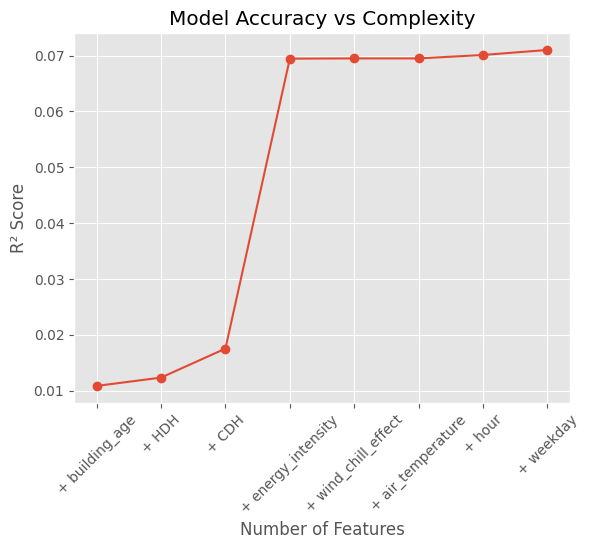

In [27]:
features = ['building_age', 'HDH', 'CDH', 'energy_intensity', 'wind_chill_effect', 'air_temperature', 'hour', 'weekday']
accuracy_scores = []

for i in range(1, len(features) + 1):
    selected_features = features[:i]
    X = train_sample[selected_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]

    X_test = X_test.dropna()
    y_test = y_test[X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # eval accuracy
    y_pred = model.predict(X_test)
    accuracy_scores.append(r2_score(y_test, y_pred))

plt.plot(range(1, len(features) + 1), accuracy_scores, marker='o')
plt.title('Model Accuracy vs Complexity')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.xticks(ticks=range(1, len(features) + 1), labels=[f'+ {feature}' for feature in features], rotation=45)
plt.show()


## 2. Exploratory Data Analysis (EDA)

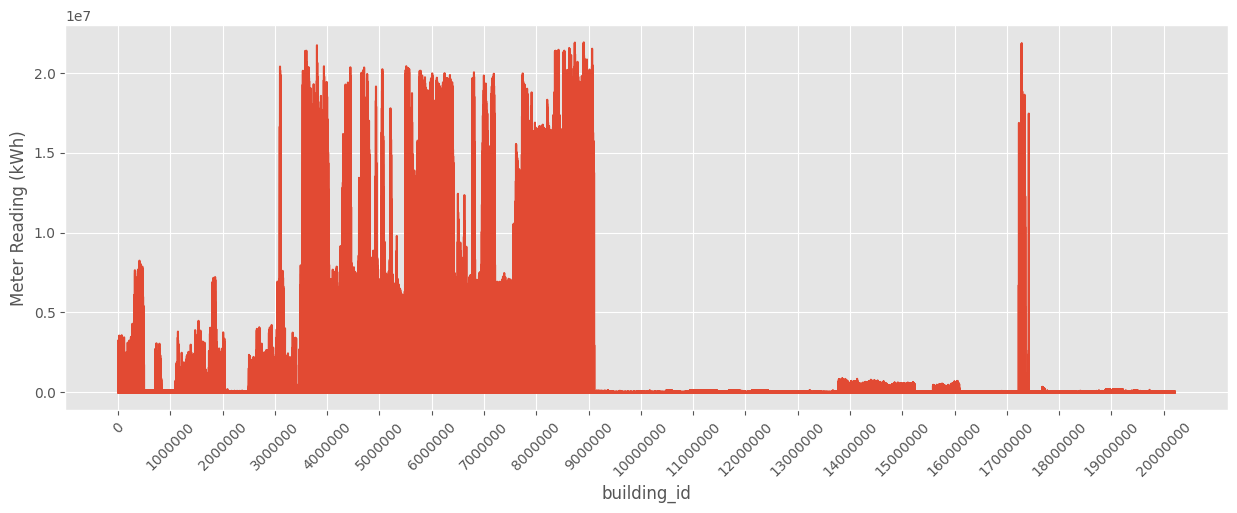

In [30]:
plt.figure(figsize = (15,5))
train_merged['meter_reading'].plot()
plt.xlabel('building_id')
plt.ylabel('meter_reading (kWh)')
plt.xticks(ticks=range(0, len(train_merged['building_id']), 1_000_000), labels=range(0, len(train_merged['building_id']), 1_000_000), rotation=45)
plt.ylabel('Meter Reading (kWh)')
plt.show()


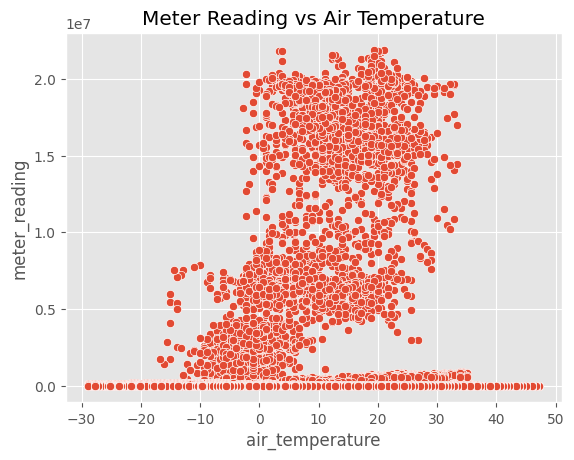

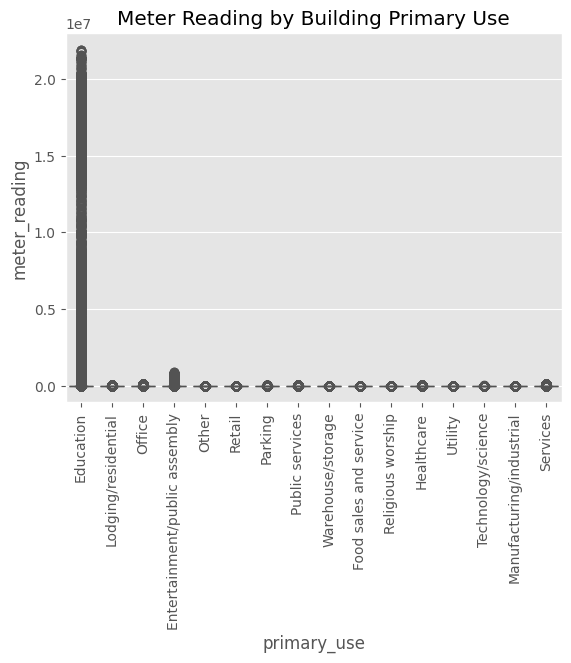

In [31]:
# Scatterplot: Meter reading vs Air Temperature
sns.scatterplot(x='air_temperature', y='meter_reading', data=train_merged)
plt.title('Meter Reading vs Air Temperature')
plt.show()

# Boxplot: Meter reading by Building Primary Use
sns.boxplot(x='primary_use', y='meter_reading', data=train_merged)
plt.xticks(rotation=90)
plt.title('Meter Reading by Building Primary Use')
plt.show()

## Init Preprocessing

In [10]:
train_merged['air_temperature'].fillna(train_merged['air_temperature'].median(), inplace=True)

# add meaningful feautures
train_merged['hour'] = pd.to_datetime(train_merged['timestamp']).dt.hour
train_merged['day_of_week'] = pd.to_datetime(train_merged['timestamp']).dt.dayofweek

/var/folders/kk/rx99trsd64s0kj15czcfjmnh0000gn/T/ipykernel_59399/669566197.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_merged['air_temperature'].fillna(train_merged['air_temperature'].median(), inplace=True)
